# Tax distribution in the USA

## Cross-sectional analysis of US tax data for 2016


### AGI bands
    1 = 1 under 25,000
    2 = 25,000 under 50,000
    3 = 50,000 under 75,000
    4 = 75,000 under 100,000
    5 = 100,000 under 200,000
    6 = 200,000 or more


## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.style as mpls
import matplotlib.ticker as ticker

In [2]:
mpls.available
mpls.use('fivethirtyeight')

## Utility functions/Helpers

In [3]:
idx = pd.IndexSlice

In [4]:
def data_for_zipcode(df, zipcode):
    """Get the data for a zipcode"""
    return df.loc[zipcode, :]

In [5]:
def summarize_zipcode(df, zipcode):
    d = data_for_zipcode(df, zipcode)
    n_exemptions = d.loc[:,'n_exemptions'].sum()
    tax = d.loc[:,'a_income_tax'].sum()
    income = d.loc[:,'a_total_income'].sum()
    if income > 0:
        tax_rate = tax/income
    else:
        tax_rate = 0
    
    tax_per_capita = tax/n_exemptions
    return {'exemptions': n_exemptions, 
            'tax': tax, 
            'income': income, 
            'tax_rate': tax_rate, 
            'tax_per_capita': tax_per_capita,
            'distro': list(d.loc[:,'a_income_tax'])}

In [6]:
midpoints = {1: 12500, 2: 37500, 3: 62500, 4: 87500, 5: 150000, 6: 500000}
midpoint_df = pd.DataFrame(index = [1,2,3,4,5,6], data = [12500, 37500, 62500, 87500, 150000, 500000], columns = ['mid'])

In [7]:
midpoint_df

,mid
1,12500
2,37500
3,62500
4,87500
5,150000
6,500000


In [8]:
def agi_midpoint(code):
    return midpoints[code]

# Data Loading and Cleaning

In [9]:
# Set this to the location of the data file 16zpallagi.csv
filepath = os.path.join(os.environ['HOME'], 'Downloads', 'zipcode2016', '16zpallagi.csv')

In [10]:
df = pd.read_csv(filepath)

In [11]:
df.columns = df.columns.str.upper()

In [12]:
df.head(6)

,STATEFIPS,STATE,ZIPCODE,AGI_STUB,N1,MARS1,MARS2,MARS4,PREP,N2,...,N10300,A10300,N85530,A85530,N85300,A85300,N11901,A11901,N11902,A11902
0,1,AL,0,1,815440,477700,105350,221200,440830,1296920,...,367320,330066,0,0,0,0,63420,51444,711580,1831661
1,1,AL,0,2,495830,211930,142340,128890,272440,996240,...,398050,984297,0,0,0,0,74090,110889,416090,1173463
2,1,AL,0,3,263390,83420,137870,36340,154880,584000,...,253180,1349246,0,0,0,0,64000,143060,195130,543284
3,1,AL,0,4,167190,29420,124060,10610,99700,421720,...,165830,1425430,0,0,0,0,45020,128920,117410,381329
4,1,AL,0,5,217440,20240,188080,4880,129410,601040,...,216720,3922449,390,155,60,19,82940,423629,126130,506526
5,1,AL,0,6,57240,2970,51130,400,42920,165770,...,57170,6208277,23170,40099,28220,89072,28900,825381,17350,254122


## Rename columns. 

Convention: 
  * n_ for counts 
  * c_ for a categorical variable 
  * a_ for amounts and totals

## Codes to include
    5-digit Zip code (code: ZIPCODE)
    Size of adjusted gross income (code: AGI_STUB)
    Net capital gain (less loss) amount: (code: A01000)
    Adjust gross income (code: A00100)
    Salaries and wages amount (code: A00200)
    Taxable income amount (code: 04800)
    Total tax credits amount (code: A07100)
    Foreign tax credit amount (code: A07300)
    Child and dependent care credit amount (code: A07180)
    Nonrefundable education credit amount (code:   A07230)
    Retirement savings contribution credit amount (code: A07240)
    Child tax credit amount (code: A07220)
    Residential energy tax credit amount (code: A07260)


In [13]:
# Columns to keep and rename to more consistent human-friendly names
column_name_map = {'ZIPCODE': 'zip', 
                   'STATEFIPS': 'code', 
                   'STATE':'state', 
                   'AGI_STUB': 'c_agi', 
                   'MARS1': 'n_single', 
                   'MARS2': 'n_married',
                  'MARS4': 'n_head', 
                   'N1': 'n_returns', 
                   'N2': 'n_exemptions',
                  'NUMDEP': 'n_dependents', 
                   'A00100': 'AGI', 
                  'A02650': 'a_total_income', 
                   'A00200': 'a_salaries',
                  'A00300': 'a_taxable_interest',
                  'N09600': 'n_amt', 
                   'A06500': 'a_income_tax',
                  'A01000': 'a_capital_gain', 
                   'A04800': 'a_taxable_income',
                  'A07100': 'a_total_tax_credits', 
                   'A07220': 'a_child_tax_credit',
                  'A07300': 'a_foreign_tax_credit', 
                   'A07260': 'a_energy_credit',
                  'A07180': 'a_child_care_credit',
                  'A07240': 'a_retirement_credit'}

In [14]:
df1 = df.loc[:,column_name_map.keys()]
df1.columns = column_name_map.values()

In [15]:
# Check that the columns that we are choosing are a subset of the columns in the original data frame.
assert set() == set(column_name_map.keys())  - set(df.columns)

In [16]:
# Number of unique zip codes

In [17]:
len(df1['zip'].unique())

29874

In [18]:
vars_to_check = ['n_returns', 'n_exemptions', 'a_child_care_credit', 'a_foreign_tax_credit', 'a_child_tax_credit', 'a_capital_gain', 'a_total_income', 'a_income_tax']

In [19]:
# Any negative values
(df1[vars_to_check]<0).sum()

n_returns                  0
n_exemptions               0
a_child_care_credit        0
a_foreign_tax_credit       0
a_child_tax_credit         0
a_capital_gain          4063
a_total_income             0
a_income_tax               0
dtype: int64

In [20]:
# Missing values
df1[vars_to_check].isnull().sum()

n_returns               0
n_exemptions            0
a_child_care_credit     0
a_foreign_tax_credit    0
a_child_tax_credit      0
a_capital_gain          0
a_total_income          0
a_income_tax            0
dtype: int64

In [21]:
ix_other = df1['zip'] == 99999
df_other = df1.loc[ix_other,:]

In [22]:
def summary(df):
    return df.groupby('zip').agg({'state': 'size', 'n_returns': ['sum', 'min', 'max', 'size'], 
                             'a_total_income': ['min', 'max', 'size', 'sum']})

In [23]:
summary(df_other)

state n_returns                  a_total_income                         
       size       sum min     max size            min      max size        sum
zip                                                                           
99999   306   1801130  60  103450  306           7034  9296853  306  138803535

Not sure what zip code 0 is. Zip code 99999 is "other".
Some basic stats for zipcode 0, 99999 data. Looks like 0 has a lot of data and a lot of returns. Is it state level aggregate?

In [24]:
ix0 = df1['zip'] == 0
df_zero = df1.loc[ix0,:]

In [25]:
summary(df_zero)

state  n_returns                     a_total_income                  \
     size        sum   min      max size            min        max size   
zip                                                                       
0     306  147025790  8480  5975580  306        1077321  603946031  306   

                  
             sum  
zip               
0    10396138255

In [26]:
df_not_zero = df1.loc[~ix0,:]

In [27]:
df_not_zero.aggregate({'state': 'size', 'n_returns': ['sum', 'min', 'max', 'size'], 
                             'a_total_income': ['min', 'max', 'size', 'sum']})

,state,n_returns,a_total_income
max,NaN,103450,10537823
min,NaN,0,0
size,179490.0,179490,179490
sum,NaN,147103270,10396112513


In [28]:
# Keep everything except zip code 0 and zip code 99999
df_final = df1.loc[~(ix0 | ix_other),:]

In [29]:
# Remove all cases of zero income and zero tax
ix_zero_income_zero_tax = (df_final['a_income_tax'] == 0) & (df_final['AGI'] == 0.0)
df_final = df_final.loc[~ix_zero_income_zero_tax,:]

## Exploratory Data Analysis


### Derived data
We're going to add some computed columns to the dataset for each zip code and AGI band. This includes the tax rate, total tax per return etc.


In [30]:
df_final['total_income_per_return'] = df_final['a_total_income']/df_final['n_returns']
df_final['total_tax_per_return'] = df_final['a_income_tax']/df_final['n_returns']
df_final['tax_rate'] = df_final['total_tax_per_return']/df_final['total_income_per_return']
df_final['cap_gain_per_return'] = df_final['a_capital_gain']/df_final['n_returns']

In [31]:
df_final['agi_midpoint'] = df_final['c_agi'].apply(agi_midpoint)

## US level data 

In [32]:
us_tax = df_final.loc[:,['n_returns','n_exemptions', 'a_taxable_income', 'a_income_tax', 'a_taxable_interest', 'a_capital_gain']].sum()

In [33]:
us_tax

n_returns              145302140
n_exemptions           281188820
a_taxable_income      7088915465
a_income_tax          1389940911
a_taxable_interest      76525047
a_capital_gain         482195036
dtype: int64

In 2016 individual taxpayers had 7 trillion dollars in income, paid 1.38 trillion dollars in taxes. They realized 482 billion dollars in capital gains and earned 76 billion dollars in interest income. The tax rate measured using this data is about 19.6% and the capital gains are about 6.8% of US income. We will use this as the baseline measures for comparison of states and zipcodes, to see what fraction of states and zip codes pay more of less than the average.

In [34]:
us_tax_total = us_tax['a_income_tax']

In [35]:
# Calculation of US tax rate
us_rate = us_tax['a_income_tax']/us_tax['a_taxable_income']
us_rate

0.19607243419145498

In [36]:
# Calculation of capital gains as share of income
cap_gains_share = us_tax['a_capital_gain']/us_tax['a_taxable_income']
cap_gains_share

0.06802098831347822

In [37]:
df_final.set_index(['zip'], inplace = True)

In [38]:
df_final.head()

,code,state,c_agi,n_single,n_married,n_head,n_returns,n_exemptions,n_dependents,AGI,...,a_child_tax_credit,a_foreign_tax_credit,a_energy_credit,a_child_care_credit,a_retirement_credit,total_income_per_return,total_tax_per_return,tax_rate,cap_gain_per_return,agi_midpoint
zip,,,,,,,,,,,,,,,,,,,,,
35004,1,AL,1,990,220,280,1510,2130,660,19351,...,15,0,0,0,12,13.029801,0.240397,0.018450,0.003311,12500
35004,1,AL,2,660,360,340,1410,2660,900,51976,...,319,0,20,63,40,37.224823,1.997872,0.053670,0.042553,37500
35004,1,AL,3,330,470,140,950,2080,660,58988,...,471,2,17,45,13,62.651579,4.972632,0.079370,0.182105,62500
35004,1,AL,4,120,470,50,650,1690,560,56302,...,423,0,6,57,0,87.164615,8.103077,0.092963,0.343077,87500
35004,1,AL,5,50,560,20,630,1800,610,81057,...,251,5,5,80,0,129.638095,15.809524,0.121951,0.607937,150000


## State level analysis

In [39]:
df_state = df_final.groupby(['state', 'code'])

In [40]:
state_summary = df_state.agg({'a_income_tax': 'sum', 'n_returns': 'sum', 'n_exemptions': 'sum'})

In [41]:
state_summary['tax_per_exemption'] = state_summary['a_income_tax']/state_summary['n_exemptions']

In [42]:
state_summary = state_summary.sort_values('tax_per_exemption', ascending=False).reset_index()

In [43]:
state_populations = pd.read_csv('nst-est2017-alldata.csv')

In [44]:
state_pop = state_populations[['STATE', 'NAME', 'POPESTIMATE2016']]

In [45]:
state_summary_final = state_summary.merge(state_pop, how='left', left_on='code', right_on='STATE')

In [46]:
font = {'family': 'Arial',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }
d = state_summary_final.sort_values('a_income_tax', ascending=False)
ax = d.plot.scatter(x='a_income_tax', y='POPESTIMATE2016', s = 100)

for i, point in d.iterrows():
    if point['state'] in ['CA', 'NJ', 'NY', 'MA', 'CT']:
        ax.text(point['a_income_tax'], point['POPESTIMATE2016'], str(point['state']), fontdict=font)
ax.set_xlabel('Income tax (Billions of USD)')
ax.set_ylabel('Population (Millions of people)')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:2.0f}'.format(x/1e6)))
ax.set_title('Do bigger states pay more tax?\n')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:2.0f}'.format(x/1e6)))
ax.figure.set_size_inches(8,6)
ax.title.set_fontsize(16)
ax.xaxis.labelpad = 20

### Exemptions as proxy for population

One claim that we wanted to verify was whether exemptions are a good estimate of population in the state. We took the census bureau data on population estimates and compared it to the number of exemptions to see how these compare. The scatter plot below shows that this is a good proxy. 

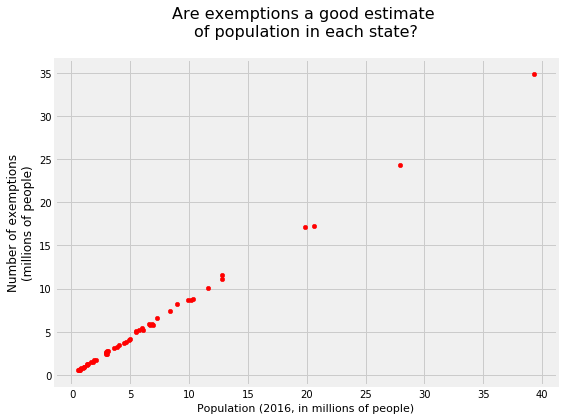

In [47]:
ax = state_summary_final.plot.scatter(x='POPESTIMATE2016', y='n_exemptions', s = 20, c='r')
ax.set_xlabel('Population (2016, in millions of people)')
ax.set_ylabel('Number of exemptions\n(millions of people)')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:2.0f}'.format(x/1e6)))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:2.0f}'.format(x/1e6)))
ax.set_title('Are exemptions a good estimate \nof population in each state?\n')
ax.figure.set_size_inches(8,6)
ax.title.set_fontsize(16)
ax.xaxis.label.set_fontsize(11)

In [48]:
state_summary_final.head()

,state,code,a_income_tax,n_returns,n_exemptions,tax_per_exemption,STATE,NAME,POPESTIMATE2016
0,DC,11,5563910,336550,525650,10.584819,11.0,District of Columbia,684336.0
1,CT,9,26875529,1724230,3148690,8.535464,9.0,Connecticut,3587685.0
2,MA,25,48672316,3352360,5940010,8.193979,25.0,Massachusetts,6823721.0
3,NY,36,122246025,9419940,17139130,7.132569,36.0,New York,19836286.0
4,NJ,34,57869246,4317050,8187260,7.068207,34.0,New Jersey,8978416.0


### DC Taxation without Representation

An informal motto for the District of Columbia has been taxatio without representation, referencing the fact that the district elects no members to congress but pays federal income tax. Since electoral votes are based on population we look at whether tax revenue is evenly distributed on a per capita basis, i.e., do individuals in different states pay tax revenue in proportion to the population of the state. Our results show that in fact DC has the highest tax revenue per capita, closely followed by Connecticut. This is probably a refelction of the number of high earners and people in high AGI bands in these states. 

In [49]:
state_summary_final['tax_per_capita'] = state_summary_final['a_income_tax']/state_summary_final['POPESTIMATE2016']

In [50]:
state_summary_final.sort_values('tax_per_capita', ascending=False).head()

,state,code,a_income_tax,n_returns,n_exemptions,tax_per_exemption,STATE,NAME,POPESTIMATE2016,tax_per_capita
0,DC,11,5563910,336550,525650,10.584819,11.0,District of Columbia,684336.0,8.130377
1,CT,9,26875529,1724230,3148690,8.535464,9.0,Connecticut,3587685.0,7.491050
2,MA,25,48672316,3352360,5940010,8.193979,25.0,Massachusetts,6823721.0,7.132812
4,NJ,34,57869246,4317050,8187260,7.068207,34.0,New Jersey,8978416.0,6.445374
3,NY,36,122246025,9419940,17139130,7.132569,36.0,New York,19836286.0,6.162748


In [51]:
df_group_state = df_final.groupby(['state'])

In [52]:
def state_hi_lo(df):
    ix_hi = df['c_agi'] == 6
    n_exemptions = df['n_exemptions'].sum()
    n_hi = df.loc[ix_hi,'n_exemptions'].sum()
    return n_hi/n_exemptions
    

In [53]:
df_state_fraction_hi = df_group_state.apply(state_hi_lo).sort_values(ascending=False).to_frame()


In [54]:
df_state_fraction_hi.columns = ['hi_per_exemption']

In [55]:
state_summary_final = state_summary_final.merge(df_state_fraction_hi, left_on = 'state', right_index=True)

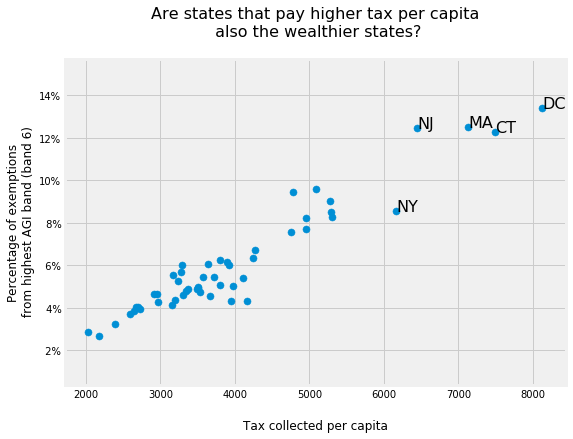

In [56]:
ax = state_summary_final.plot.scatter(x='tax_per_capita', y='hi_per_exemption', s= 50)
for i, point in state_summary_final.iterrows():
    if point['tax_per_capita'] > 6:
        ax.text(point['tax_per_capita'], point['hi_per_exemption'], str(point['state']), size=16)
ax.figure.set_size_inches(8, 6)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:2.0f}%'.format(100*x)))
ax.set_ylabel('Percentage of exemptions\n from highest AGI band (band 6)')
ax.set_xlabel('Tax collected per capita')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:2.0f}'.format(1000*x)))
ax.set_title('Are states that pay higher tax per capita\n also the wealthier states?\n')
ax.title.set_fontsize(16)
ax.xaxis.labelpad = 20

### Zipcode with highest total income 

In [57]:
df_g = df_final.groupby(df_final.index)

In [58]:
df_total = df_g.agg({'a_total_income': 'sum', 'a_income_tax': 'sum'})

In [59]:
ix_max = df_total.idxmax()

In [60]:
ix_max

a_total_income    10023
a_income_tax      10023
dtype: int64

In [61]:
df_final.loc[ix_max[0], :].sum()

code                                216
state                      NYNYNYNYNYNY
c_agi                                21
n_single                          21740
n_married                          9540
n_head                             1680
n_returns                         34070
n_exemptions                      52060
n_dependents                       9670
AGI                            11766656
a_total_income                 11936570
a_salaries                      5856720
a_taxable_interest               466538
n_amt                              8600
a_income_tax                    2747241
a_capital_gain                  2123982
a_taxable_income                9351020
a_total_tax_credits               70908
a_child_tax_credit                  787
a_foreign_tax_credit              59364
a_energy_credit                     387
a_child_care_credit                 736
a_retirement_credit                  85
total_income_per_return         1395.97
total_tax_per_return             302.96


### Zip code is the upper east side on Central Park in NYC


## Zipcode with lowest total income

In [62]:
ix_min = df_total.idxmin()

In [63]:
ix_min

a_total_income    79406
a_income_tax      59467
dtype: int64

In [64]:
df_final.loc[ix_min['a_income_tax'], :]

code                          30
state                         MT
c_agi                          1
n_single                      70
n_married                     30
n_head                         0
n_returns                    100
n_exemptions                 150
n_dependents                   0
AGI                         1174
a_total_income              1174
a_salaries                     0
a_taxable_interest             0
n_amt                          0
a_income_tax                   0
a_capital_gain                60
a_taxable_income               0
a_total_tax_credits            0
a_child_tax_credit             0
a_foreign_tax_credit           0
a_energy_credit                0
a_child_care_credit            0
a_retirement_credit            0
total_income_per_return    11.74
total_tax_per_return           0
tax_rate                       0
cap_gain_per_return          0.6
agi_midpoint               12500
Name: 59467, dtype: object

Lowest total income is in Texas Tech University and Lubock texas. Makes sense mostly students.m

### Take a look at some data for different zip codes

Test a zipcode to see what results look like. 
94305 Palo Alto zipcode for Stanford
48208 neighbourhood in Detroit

In [65]:
data_for_zipcode(df_final, 94305) # Palo Alto

,code,state,c_agi,n_single,n_married,n_head,n_returns,n_exemptions,n_dependents,AGI,...,a_child_tax_credit,a_foreign_tax_credit,a_energy_credit,a_child_care_credit,a_retirement_credit,total_income_per_return,total_tax_per_return,tax_rate,cap_gain_per_return,agi_midpoint
zip,,,,,,,,,,,,,,,,,,,,,
94305,6,CA,1,690,30,0,730,560,0,8245,...,0,4,0,0,7,11.834247,0.302740,0.025582,0.249315,12500
94305,6,CA,2,980,60,0,1060,1150,80,39904,...,25,4,0,0,0,38.013208,3.037736,0.079913,0.263208,37500
94305,6,CA,3,260,40,0,310,390,40,18695,...,30,2,0,0,0,61.277419,6.893548,0.112497,1.332258,62500
94305,6,CA,4,110,60,0,170,270,40,15165,...,30,2,0,0,0,90.370588,11.652941,0.128946,0.964706,87500
94305,6,CA,5,170,180,40,370,680,140,53695,...,22,51,0,29,0,146.335135,22.189189,0.151633,2.772973,150000
94305,6,CA,6,110,670,0,800,2160,690,511820,...,0,1254,79,53,0,653.122500,150.805000,0.230898,38.768750,500000


In [66]:
data_for_zipcode(df_final, 48208) # Detroit

,code,state,c_agi,n_single,n_married,n_head,n_returns,n_exemptions,n_dependents,AGI,...,a_child_tax_credit,a_foreign_tax_credit,a_energy_credit,a_child_care_credit,a_retirement_credit,total_income_per_return,total_tax_per_return,tax_rate,cap_gain_per_return,agi_midpoint
zip,,,,,,,,,,,,,,,,,,,,,
48208,26,MI,1,1140,30,630,1820,2950,1180,21553,...,20,0,0,0,12,12.062088,0.153846,0.012755,0.000549,12500
48208,26,MI,2,420,40,240,720,1180,430,24881,...,120,0,5,37,18,34.868056,1.959722,0.056204,0.112500,37500
48208,26,MI,3,120,40,50,200,320,80,11873,...,46,0,0,12,0,59.950000,5.925000,0.098832,0.140000,62500
48208,26,MI,4,50,30,0,90,170,50,7539,...,50,0,0,0,0,84.188889,10.288889,0.122212,0.000000,87500
48208,26,MI,5,20,60,0,90,210,60,15297,...,0,0,0,0,0,171.122222,28.033333,0.163821,8.711111,150000


In [67]:
s = summarize_zipcode(df_final, 10023)

In [68]:
s['tax']/s['exemptions'], s['tax']/s['income']

(52.770668459469846, 0.23015330199546435)

## Tax revenue generated

In [69]:
%matplotlib inline

In [70]:
df_tax = df_final['a_income_tax']

In [71]:
total_income_tax = df_tax.sum()

In [72]:
total_income_tax

1389940911

In [73]:
# Zip codes that generate more than a 0.1% in tax revenue. 
ix_bill = df_tax > total_income_tax*0.001


In [74]:
df_tax.loc[ix_bill].count()

16

In [75]:
df_final.loc[ix_bill,:]

,code,state,c_agi,n_single,n_married,n_head,n_returns,n_exemptions,n_dependents,AGI,...,a_child_tax_credit,a_foreign_tax_credit,a_energy_credit,a_child_care_credit,a_retirement_credit,total_income_per_return,total_tax_per_return,tax_rate,cap_gain_per_return,agi_midpoint
zip,,,,,,,,,,,,,,,,,,,,,
94010,6,CA,6,650,5340,190,6320,19120,7470,6470805,...,0,22163,794,502,0,1037.180222,255.417247,0.246261,240.834810,500000
94025,6,CA,6,900,4810,230,6060,17620,6760,5572657,...,0,16540,550,473,0,932.095710,229.628383,0.246357,190.335314,500000
94301,6,CA,6,660,2370,140,3250,8570,2950,10496796,...,0,33574,158,155,0,3242.407077,667.714462,0.205932,1051.724923,500000
94303,6,CA,6,380,2860,100,3390,10640,4390,5339560,...,0,12230,250,261,0,1581.161652,504.479646,0.319056,557.224484,500000
6830,9,CT,6,450,2430,130,3110,9020,3490,5975681,...,0,42051,89,125,0,1945.478778,482.257556,0.247886,465.246302,500000
60614,17,IL,6,1410,5160,170,6820,17920,5950,5952266,...,0,28787,167,434,0,886.750587,222.399560,0.250803,279.163343,500000
10011,36,NY,6,3810,3320,190,7470,13420,2640,6299474,...,0,34715,54,223,0,855.089157,215.477644,0.251994,140.663722,500000
10013,36,NY,6,1260,2290,130,3800,8990,2900,5689422,...,0,47387,0,211,0,1514.667895,396.412895,0.261716,355.540000,500000
10021,36,NY,6,2010,4460,210,6910,15900,4540,9323033,...,0,36339,255,345,0,1365.396382,333.132996,0.243983,314.150217,500000


## plot tax revenue distribution

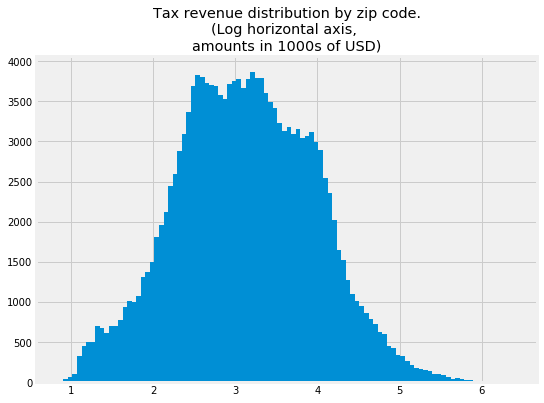

In [76]:
# Filter out 0 tax zipcodes (what are these?)
# Take log to make data easier to plot and show historgram of tax revenue in each zip code
ax = df_tax[df_tax > 0].transform(np.log10).hist(bins = 100)
ax.set_title('Tax revenue distribution by zip code.\n(Log horizontal axis, \namounts in 1000s of USD)')
ax.figure.set_size_inches((8, 6)) 
ax.figure.savefig('tax distribution.png')

### Compare tax rates of highest and lowest income bands.


In [77]:
# Index of second highest and second lowest AGI bands
ix_low = df_final['c_agi'] == 1
ix_high = df_final['c_agi'] == 6
df_high = df_final.loc[ix_high,:]
df_low = df_final.loc[ix_low,:]

In [78]:
tax_high = df_high['a_income_tax'].sum()/df_high['a_total_income'].sum()

In [79]:
tax_low = df_low['a_income_tax'].sum()/df_low['a_total_income'].sum()

In [80]:
tax_high, tax_low

(0.2292903929414641, 0.017844136327953192)

### Tax share

In [81]:
df_final.loc[:,'share'] = df_final.loc[:,'a_income_tax']/us_tax_total

In [82]:
def summarize(df):
    return {'max': df.max(),
            'min': df.min(),
            'mean': df.mean()}

In [83]:
df_final['share'].apply([np.min, np.max, np.mean, np.median])

amin      0.000000e+00
amax      1.804368e-03
mean      6.276558e-06
median    8.985994e-07
Name: share, dtype: float64

In [84]:
df_final.head()

,code,state,c_agi,n_single,n_married,n_head,n_returns,n_exemptions,n_dependents,AGI,...,a_foreign_tax_credit,a_energy_credit,a_child_care_credit,a_retirement_credit,total_income_per_return,total_tax_per_return,tax_rate,cap_gain_per_return,agi_midpoint,share
zip,,,,,,,,,,,,,,,,,,,,,
35004,1,AL,1,990,220,280,1510,2130,660,19351,...,0,0,0,12,13.029801,0.240397,0.018450,0.003311,12500,2.611622e-07
35004,1,AL,2,660,360,340,1410,2660,900,51976,...,0,20,63,40,37.224823,1.997872,0.053670,0.042553,37500,2.026705e-06
35004,1,AL,3,330,470,140,950,2080,660,58988,...,2,17,45,13,62.651579,4.972632,0.079370,0.182105,62500,3.398706e-06
35004,1,AL,4,120,470,50,650,1690,560,56302,...,0,6,57,0,87.164615,8.103077,0.092963,0.343077,87500,3.789370e-06
35004,1,AL,5,50,560,20,630,1800,610,81057,...,5,5,80,0,129.638095,15.809524,0.121951,0.607937,150000,7.165772e-06


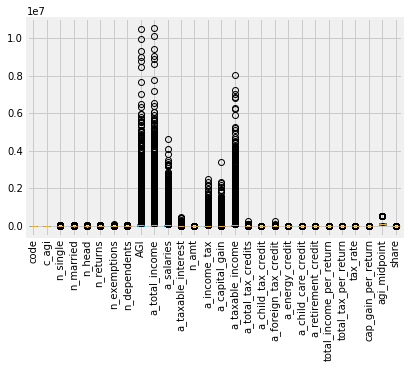

In [85]:
df_final.plot.box(by='c_agi', rot = 90) #.pivot(columns='c_agi') # 

In [86]:
df_final['log_tax'] = np.log(df_final['a_income_tax']) #.pivot_table(columns = 'c_agi', 
                                                       #    values='a_taxable_income', index = 'zip', aggfunc = lambda x: np.log(1 + x)).plot.box()

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


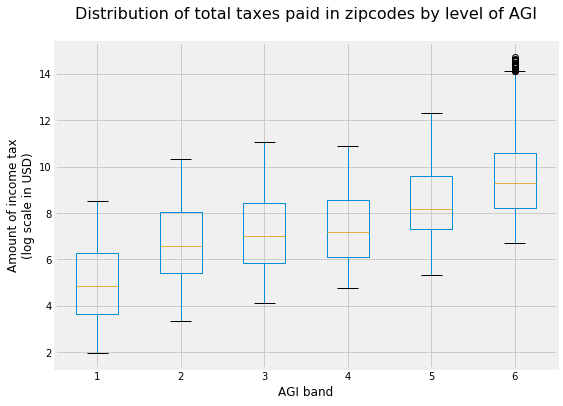

In [87]:
ax = df_final.pivot_table(columns = 'c_agi', values='log_tax', index = 'zip').plot.box()
ax.set_title('Distribution of total taxes paid in zipcodes by level of AGI\n')
ax.set_xlabel('AGI band')
ax.title.set_fontsize(16)
ax.set_ylabel('Amount of income tax\n(log scale in USD)')
ax.figure.set_size_inches(8, 6)

Note that this is as expected with higher income paying more tax than lower income across zipcodes. The highest income band doesn't have a cap on AGI so this includes all pepole show make more than $200,000 per year. This group contains some outliers who pay a lot of tax. In the next piece of analysis we look to see how income and tax are concentrated. To do this we look to where the 99th percentile of the tax distrubtion is and find how many zipcodes contribute to the top 1%. 

In [88]:
df_high = df_final.loc[df_final['c_agi'] == 6, :]

In [89]:
df_high_zero_tax = df_high.loc[df_high['a_income_tax'] == 0,:]

In [90]:
df_zero_tax_but_agi = df_high_zero_tax.loc[df_high_zero_tax['AGI'] != 0,:]

In [91]:
df_zero_tax_but_agi.head()

,code,state,c_agi,n_single,n_married,n_head,n_returns,n_exemptions,n_dependents,AGI,...,a_energy_credit,a_child_care_credit,a_retirement_credit,total_income_per_return,total_tax_per_return,tax_rate,cap_gain_per_return,agi_midpoint,share,log_tax
zip,,,,,,,,,,,,,,,,,,,,,
35622,1,AL,6,0,0,0,20,60,30,8540,...,0,0,0,427.00,0.0,0.0,0.0,500000,0.0,-inf
36558,1,AL,6,0,20,0,20,60,0,8440,...,0,0,0,422.00,0.0,0.0,0.0,500000,0.0,-inf
72638,5,AR,6,0,0,0,20,50,0,8252,...,0,0,0,412.60,0.0,0.0,0.0,500000,0.0,-inf
90011,6,CA,6,0,0,0,20,50,20,16683,...,0,0,0,834.15,0.0,0.0,0.0,500000,0.0,-inf
93258,6,CA,6,0,0,0,20,40,0,6161,...,0,0,0,308.05,0.0,0.0,0.0,500000,0.0,-inf


Looks like there are people who have zero income and zero tax in the data set, we shuld filter this out.

In [92]:
df_high_zero_tax.shape

(35, 30)

## Capital gains

In [146]:
df_cap_gain = df_final[['state', 'AGI', 'c_agi', 'n_returns', 'a_total_income', 'a_income_tax', 'a_capital_gain']]

In [147]:
df_final.head()

,code,state,c_agi,n_single,n_married,n_head,n_returns,n_exemptions,n_dependents,AGI,...,a_energy_credit,a_child_care_credit,a_retirement_credit,total_income_per_return,total_tax_per_return,tax_rate,cap_gain_per_return,agi_midpoint,share,log_tax
zip,,,,,,,,,,,,,,,,,,,,,
35004,1,AL,1,990,220,280,1510,2130,660,19351,...,0,0,12,13.029801,0.240397,0.018450,0.003311,12500,2.611622e-07,5.894403
35004,1,AL,2,660,360,340,1410,2660,900,51976,...,20,63,40,37.224823,1.997872,0.053670,0.042553,37500,2.026705e-06,7.943428
35004,1,AL,3,330,470,140,950,2080,660,58988,...,17,45,13,62.651579,4.972632,0.079370,0.182105,62500,3.398706e-06,8.460411
35004,1,AL,4,120,470,50,650,1690,560,56302,...,6,57,0,87.164615,8.103077,0.092963,0.343077,87500,3.789370e-06,8.569216
35004,1,AL,5,50,560,20,630,1800,610,81057,...,5,80,0,129.638095,15.809524,0.121951,0.607937,150000,7.165772e-06,9.206332


In [148]:
df_cap_gain['cap_gain_share_income'] = df_cap_gain['a_capital_gain']/df_cap_gain['AGI']

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [149]:
df_cap_gain_pivot = df_cap_gain.pivot_table(columns = 'c_agi', values='cap_gain_share_income', aggfunc=['median'])

In [150]:
df_cap_gain_share = df_cap_gain_pivot.unstack().reset_index(level=[0,2], drop=True).to_frame().merge(midpoint_df, left_index =True, right_index=True)

In [151]:
df_cap_gain_share['ratio'] = df_cap_gain_share[0]/df_cap_gain_share['mid']*1000000

In [152]:
df_cap_gain_share

,0,mid,ratio
c_agi,,,
1,0.001451,12500,0.116079
2,0.002930,37500,0.078134
3,0.005174,62500,0.082779
4,0.006130,87500,0.070060
5,0.015116,150000,0.100771
6,0.062657,500000,0.125313


We would expect that capital gains make up a small percent of the income in lower bands. However comparing the the share of capital gains to total income shows that people in lower income bands have less capital gains. In AGI band 1 for example about 0.1% of income is from capital gains, while in AGI band 5 it is almost 1.5%. For high income (AGI band 6) the share of income climbs quickly to 6% of the income. 

In [ ]:
df_cap_gain_pivot = df_cap_gain.pivot_table(values = ['cap_gain_share_income'], index='c_agi', aggfunc = {'a_capital_gain': 'sum',
                                                                                           'n_returns': 'sum'})

In [ ]:
df_cap_gain_pivot['per_return'] = df_cap_gain_pivot['a_capital_gain']/df_cap_gain_pivot['n_returns']

In [ ]:
df_cap_gain_pivot

In [94]:
df_cap_gain.pivot_table?

Object `df_cap_gain.pivot_table` not found.


## Income vs tax

In [95]:
df_income_to_tax = df_final[['a_income_tax', 'a_total_income']]
ix = (df_income_to_tax['a_income_tax'] == 0) | (df_income_to_tax['a_total_income'] == 0)
df_income_to_tax = df_income_to_tax[~ix]

In [96]:
df_income_to_tax

,a_income_tax,a_total_income
zip,,
35004,363,19675
35004,2817,52487
35004,4724,59519
35004,5267,56657
35004,9960,81672
35004,3951,20250
35005,279,18061
35005,1611,35066
35005,2073,27538


In [97]:
df_income_to_tax['ratio'] = df_income_to_tax['a_total_income']/df_income_to_tax['a_income_tax']

In [98]:
df_income_to_tax['ratio'].mean()

19.973201893646856

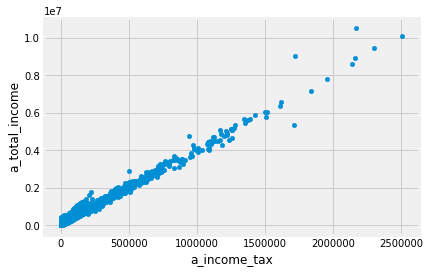

In [99]:
df_income_to_tax.plot.scatter(x = 'a_income_tax', y = 'a_total_income')

In [100]:
df_income_to_tax['ratio'].mean

<bound method Series.mean of zip
35004    54.201102
35004    18.632233
35004    12.599280
35004    10.756977
35004     8.200000
35004     5.125285
35005    64.734767
35005    21.766605
35005    13.284129
35005    10.871698
35005     7.842418
35006    55.104762
35006    21.238011
35006    13.248330
35006    11.011179
35006     7.836725
35007    56.128779
35007    20.655260
35007    13.293200
35007    11.194564
35007     8.207890
35007     4.739301
35010    74.049550
35010    22.716137
35010    13.330125
35010    11.370426
35010     8.273073
35010     4.846163
35014    76.104348
35014    23.210227
           ...    
83122    48.333333
83122    27.500000
83122    13.726415
83122    10.163009
83123    66.187500
83123    20.097087
83123    11.045714
83123    10.828179
83123     6.735029
83126    15.058824
83126    16.294574
83126    13.458065
83126     9.205374
83127    68.441176
83127    20.445826
83127    13.740392
83127    11.223762
83127     8.149502
83127     4.240042
83128    42.37142

In [101]:
df_income_to_tax['a_income_tax'].sort_values().cumsum()

zip
76957             7
99765            14
36529            22
12427            30
80729            38
10545            46
82244            54
15047            62
69121            70
66936            78
83271            86
67111            94
68932           102
99627           110
16370           118
5853            127
72030           136
61312           145
38552           154
12886           163
27556           172
39167           181
23897           190
72134           199
26237           208
99551           217
99552           226
28554           235
6467            244
99630           253
            ...    
12866    1344304416
90272    1345523497
90024    1346744347
77024    1347979503
10019    1349226196
60611    1350473952
75225    1351729448
94022    1352986982
10003    1354246150
10075    1355520426
33480    1356797604
20854    1358143480
90210    1359497620
90049    1360869920
94025    1362261468
10065    1363689449
6830     1365189270
10013    1366695639
60614    1368212

## Credits

How are credits distributed across the population by income. We consider the credits that are available. Energy, Child, Foreign tax, Retirement, Child care. We calculate the total for each of these credits per exemption by AGI band.

In [102]:
credit_columns = df_final.columns[df_final.columns.str.contains('credit')]

In [103]:
df_credits = df_final[['c_agi','n_exemptions'] + list(credit_columns)]

In [104]:
def credit_summary(df):
    n = df['n_exemptions'].sum()
    df1 = df[credit_columns]
    # Convert back to dollars from 1000s of dollars
    return 1000*df1.sum()/n
    

In [105]:
df_credits.groupby('c_agi').apply(credit_summary)

,a_total_tax_credits,a_child_tax_credit,a_foreign_tax_credit,a_energy_credit,a_child_care_credit,a_retirement_credit
c_agi,,,,,,
1,29.577945,7.025756,0.165960,0.179274,1.342530,4.871480
2,178.404172,104.559691,0.880428,3.223941,13.709336,13.806768
3,267.542062,186.950322,2.661134,7.865285,13.780532,4.860204
4,291.955863,200.638697,4.383598,9.968876,17.322651,0.000000
5,220.474449,98.624697,14.709979,16.045893,21.467639,0.000000
6,711.049211,0.007413,445.062071,20.841351,18.818011,0.000000


In [121]:
file_lat_lon = filepath = os.path.join(os.environ['HOME'], 'Downloads', '2016_Gaz_zcta_national.txt')

In [128]:
lat_long = pd.read_csv(file_lat_lon, delimiter='\t')

In [ ]:
lat_long.columns = lat_long.columns.str.strip()

In [129]:
lat_long.head()

,GEOID,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,601,166659884,799293,64.348,0.309,18.180555,-66.749961
1,602,79287203,4448761,30.613,1.718,18.361945,-67.175597
2,603,81884707,183895,31.616,0.071,18.455183,-67.119887
3,606,109579998,12487,42.309,0.005,18.158345,-66.932911
4,610,93020979,4171994,35.916,1.611,18.295366,-67.125135


In [130]:
df_final.index.max()

99929

In [134]:
df_zip = df_final.groupby(df_final.index).aggregate({'a_income_tax': 'sum', 'n_exemptions':'sum'})

In [135]:
df_zip['per_exemption'] = df_zip['a_income_tax']/df_zip['n_exemptions']

In [136]:
df_map = df_zip.merge(lat_long, left_index = True, right_on = 'GEOID')

In [137]:
from matplotlib import cm


In [138]:
cmap = cm.get_cmap('Spectral')

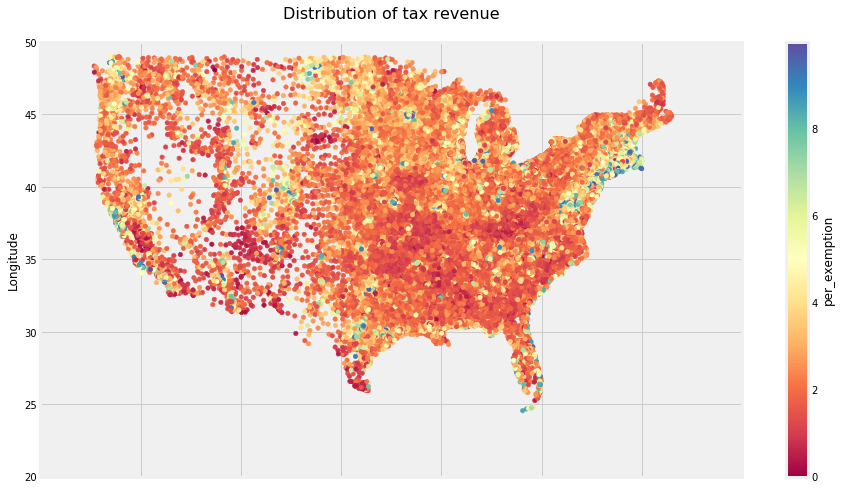

In [139]:
ix = (df_map['INTPTLONG'] < 0) & (df_map['INTPTLAT'] > 0) &  (df_map['per_exemption'] < 10)

ax = df_map.loc[ix,:].plot.scatter(y='INTPTLAT', x='INTPTLONG', c='per_exemption', cmap = cmap)
ax.set_xlim([-130,-60])
ax.set_ylim([20,50])
ax.figure.set_size_inches(14, 8)
ax.set_title('Distribution of tax revenue\n')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.xaxis.labelpad = 40
ax.title.set_fontsize(16)

In [153]:
import ipywidgets as widgets

In [211]:
from bqplot import (
    OrdinalScale, LinearScale, Bars, Lines, Axis, Figure
)



In [212]:
zipcode_input_1 = widgets.Text(
    value='',
    placeholder='Zipcode',
    description='Zip code:',
    disabled=False   
)

In [213]:
zipcode_input_2 = widgets.Text(
    value='',
    placeholder='Zipcode',
    description='Zip code:',
    disabled=False   
)

In [214]:
lookup_btn = widgets.Button(
    description='Lookup',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Lookup zip code',
    icon='search'
)

In [215]:
us_output = widgets.HTML(value = "")
us_output.value = "<h3>US summary</h3><p>The US collected {0:,.0f} B in taxes with the average tax rate being {1:2.0f}%".format(us_tax_total/1e6, 100*us_rate)

In [216]:
output_1 = widgets.HTML(
    value="X",
    placeholder='',
    description='',
    layout = {'width': '50%'}
)
output_2 = widgets.HTML(
    value="Y",
    placeholder='',
    description='',
    layout = {'width': '50%'}
)

In [217]:
def format_summary(d):
    text = ["<b>Exemptions</b>: {exemptions:,d}",
            "<b>Tax (M of USD)</b>: {tax:,.0f}",
            "<b>Income (M of USD)</b>: {income:,.0f}",
            "<b>Tax per capita (1000s USD)</b>: {tax_per_capita:2.0f}",
            "<b>Tax rate</b>: {tax_rate:2.0f}%</b>"]
    s = "\n".join(["<li>{0}</li>".format(t) for t in text])
    d['income'] = d['income']/1000
    d['tax'] = d['tax']/1000
    d['tax_rate']  = 100*d['tax_rate']
    return s.format(**d)

In [224]:
def lookup(btn):
    zip_1 = int(zipcode_input_1.value)
    zip_2 = int(zipcode_input_2.value)
    d1 = summarize_zipcode(df_final, zip_1)
    s1 = """
    <h3 style="color: blue;">Zip code: {0}</h3><p><ul>{1}</ul></p>"
    """.format(zip_1, format_summary(d1))
    d2 = summarize_zipcode(df_final, zip_2)
    s2 = """
    <h3 style="color: red;">Zip code: {0}</h3><p><ul>{1}</ul></p>"
    """.format(zip_2, format_summary(d2))
    output_1.value = s1
    output_2.value = s2
    x = [1,2,3,4,5,6]
    y1 = d1['distro']
    y2 = d2['distro']
    x_ord = OrdinalScale()
    y_sc = LinearScale()
    bar = Bars(x=x, y=[y1, y2], type='grouped', 
               colors = ['blue', 'red'], scales={'x': x_ord, 
                                 'y': y_sc})
    fig.marks = [bar]

In [225]:
lookup_btn.on_click(lookup)

In [226]:

x_ord = OrdinalScale()
y_sc = LinearScale()

marks = [Bars(x=[1,2,3,4,5,6], y= [[0,0,0,0,0,0],[0,0,0,0,0,0]], 
                  scales={"x": x_ord, 
                          "y": y_sc})]

ax_x = Axis(scale=x_ord, orientation='horizontal',
            grid_lines='solid', label='AGI bannd')
ax_y = Axis(scale=y_sc, orientation='vertical', tick_format='0.2f',
            grid_lines='solid', label='%')

fig = Figure(axes=[ax_x, ax_y], 
             marks=marks,
             title='Income tax distribution',
             legend_location='bottom-right')


In [227]:
widgets.VBox([widgets.HBox([zipcode_input_1, zipcode_input_2, lookup_btn]), 
              widgets.HBox([us_output]), 
              widgets.HBox([output_1, output_2]),
              widgets.HBox([fig])], 
             layout={'height': '800px'})